In [6]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from order_book import *
from ml import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ob_data = load_ob_data(
    folder = 'data/',
    contract = 'CAKEUSDT',
    start_date = datetime(2025, 2, 8),
    end_date = datetime(2025, 2, 8),
    exchange = "bybit")

In [7]:
snapshots = build_bucket_snapshots(ob_data, timedelta(seconds=5), 10, 0.01)

In [11]:
snapshots[3]

{'timestamp': datetime.datetime(2025, 2, 8, 1, 0, 16, 73000),
 'midprice': 1.3965,
 'bids': [131082.80000000002,
  119849.20000000001,
  36909.200000000004,
  19840.200000000004,
  27899.5,
  11305.199999999997,
  1431.9,
  227.4,
  5.0,
  30058.19999999994],
 'asks': [43491.60000000005,
  30.5,
  27.900000000000002,
  12.599999999999998,
  5.1,
  2893.5,
  7465.799999999998,
  64756.899999999994,
  105293.1,
  70234.1],
 'num_bid_takers': 1,
 'num_ask_takers': 0,
 'size_bid_takers': 8.3,
 'size_ask_takers': 0,
 'vwap': 1.397}

TypeError: list indices must be integers or slices, not float

In [102]:
X_data, Y_data = build_bucket_data_set(bucket_snapshots, 60, 5, 50)

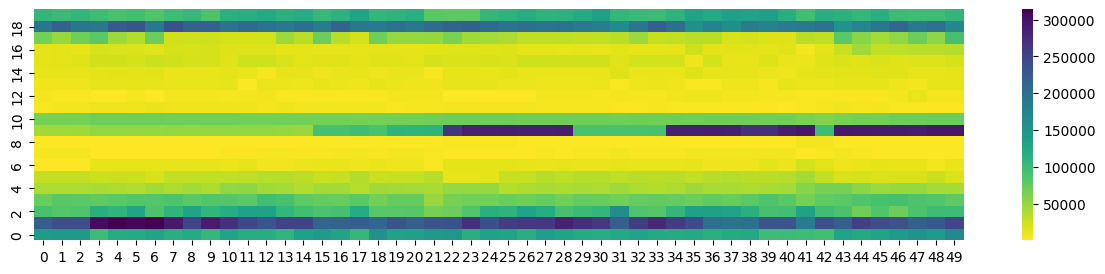

In [130]:
plt.figure(figsize=(15, 3))
sns.heatmap(X_data[2714].T, cmap='viridis_r') #, vmin=-0.5, vmax=0.5)
plt.gca().invert_yaxis()
plt.show()

In [95]:
train_split = int(len(X_data) * 0.8)
x_train, y_train = X_data[:train_split], Y_data[:train_split]
x_val, y_val = X_data[train_split:], Y_data[train_split:]

In [96]:
# Compute mean and std along the samples axis (axis 0)
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)

# Normalize while preserving 3D structure
x_train = (x_train - train_mean) / train_std
x_val = (x_val - train_mean) / train_std

In [97]:
std_y = np.std(y_train, axis=0)

y_train = (y_train) / std_y
y_val = (y_val) / std_y

In [98]:
train_dataset = OrderBookDataset(x_train, y_train)
val_dataset = OrderBookDataset(x_val, y_val)

In [99]:
class AttentionModel(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        # Initial CNN layers
        self.conv_first = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2)),  # Input channels should be 1
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, kernel_size=(4, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, kernel_size=(4, 1), padding='same'),
            nn.LeakyReLU(0.01),
            
            nn.Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, kernel_size=(4, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, kernel_size=(4, 1), padding='same'),
            nn.LeakyReLU(0.01),
            
            #nn.Conv2d(32, 32, kernel_size=(1, 10)),
            #nn.LeakyReLU(0.01),
            #nn.Conv2d(32, 32, kernel_size=(4, 1), padding='same'),
            #nn.LeakyReLU(0.01),
            #nn.Conv2d(32, 32, kernel_size=(4, 1), padding='same'),
            #nn.LeakyReLU(0.01)
        )
        
        # Inception module
        self.inception_1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(0.01)
        )
        
        self.inception_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(0.01)
        )
        
        self.inception_3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(32, 64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(0.01)
        )
        
        # LSTM layer
        self.encoder_lstm = nn.LSTM(192, latent_dim, batch_first=True)
        
        # Output heads for mean and variance
        self.mean_head = nn.Linear(latent_dim, 1)
        self.log_var_head = nn.Sequential(
            nn.Linear(latent_dim, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Ensure input is the right shape
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # Add channel dimension if not present
            
        # CNN feature extraction
        x = self.conv_first(x)
        
        # Inception module
        branch1 = self.inception_1(x)
        branch2 = self.inception_2(x)
        branch3 = self.inception_3(x)
        
        x = torch.cat([branch1, branch2, branch3], dim=1)
        
        # Reshape for LSTM
        x = x.reshape(batch_size, -1, x.size(1))
        
        # LSTM
        lstm_out, (state_h, state_c) = self.encoder_lstm(x)
        
        # Use final state for prediction
        final_state = state_h[-1]
        
        # Predict mean and variance
        mean = self.mean_head(final_state)
        log_var = self.log_var_head(final_state)
        var = torch.exp(log_var).clamp(min=1e-6, max=1e6)
        
        return mean, var

In [100]:
model = AttentionModel(32)
criterion = LL_Loss()

In [131]:
train_network(model, train_dataset, val_dataset, criterion, epochs=10, batch_size=32, lr=0.0001)

Epoch 1, Train Loss: 0.341041, Val Loss: 0.277492
Epoch 2, Train Loss: 0.330090, Val Loss: 0.265912
Epoch 3, Train Loss: 0.316841, Val Loss: 0.252196
Epoch 4, Train Loss: 0.306457, Val Loss: 0.315152
Epoch 5, Train Loss: 0.302628, Val Loss: 0.263653
Epoch 6, Train Loss: 0.284696, Val Loss: 0.264583
Epoch 7, Train Loss: 0.273735, Val Loss: 0.267835
Epoch 8, Train Loss: 0.260673, Val Loss: 0.278263
Epoch 9, Train Loss: 0.252944, Val Loss: 0.280671
Epoch 10, Train Loss: 0.243449, Val Loss: 0.286398


In [ ]:
train_network(model, train_dataset, val_dataset, criterion, epochs=10, batch_size=32, lr=0.0001)

In [133]:
mean, var = model(torch.tensor(x_val, dtype=torch.float32))

In [134]:
mean = np.array(mean.squeeze().tolist())
var = np.array(var.squeeze().tolist())

In [135]:
# denormalize
mean *= std_y
var *= std_y**2

In [136]:
def conf(mean, var):

    std = np.sqrt(var)
    
    # Calculate probability less than 0
    prob_less_than_zero = norm.cdf(0, mean, std)
    
    # If prob_less_than_zero > 0.5, return area from -inf to 0
    # If prob_less_than_zero <= 0.5, return area from 0 to +inf
    if prob_less_than_zero > 0.5:
        return prob_less_than_zero
    else:
        return 1 - prob_less_than_zero

In [137]:
conf = np.array([conf(m, v) for m, v in zip(mean, var)])

140

In [151]:
keep = (conf > 0.85)
keep.sum()

8

In [152]:
# Get predictions and truth
y_pred = mean[keep] > 0
y_true = y_val[keep] > 0

# Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

# Calculate accuracy
accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
print(f"\nAccuracy: {accuracy:.4f}")

Confusion Matrix:
TN: 4, FP: 0
FN: 3, TP: 1

Accuracy: 0.6250


In [153]:
(y_val > 0).sum()/len(y_val)

0.5064143007360673

In [154]:
(y_train > 0).sum()/len(y_train)

0.48283295651716707

In [159]:
df[df["trdMatchID"] == "1be004fb-a7b9-5ec5-b565-1544e6ac2c23"]

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
0,1.739059e+09,CAKEUSDT,Buy,222.1,1.695,ZeroMinusTick,1be004fb-a7b9-5ec5-b565-1544e6ac2c23,3.764595e+10,222.1,376.4595


In [179]:
import gzip
import pandas as pd

def load_trade_data(
    folder,
    contract,
    start_date,
    end_date,
    exchange = "bybit"):
    
    
    trades = []
    curr_date = start_date
    while curr_date <= end_date:
    
        filepath = f"{folder}{contract}{curr_date.year}-{zero_pad(curr_date.month)}-{zero_pad(curr_date.day)}.csv.gz"
    
        df = pd.read_csv('data/trades/CAKEUSDT2025-02-09.csv.gz', compression='gzip')
    
        x = 0
        
        for i in range(len(df)):
            x += df.iloc[i]["price"]
            #trades.append({
            #    'timestamp' : datetime.fromtimestamp(df.iloc[i]["timestamp"]),
            #    'price' : df.iloc[i]["price"],
            #    'size' : df.iloc[i]["size"],
            #    'side' : df.iloc[i]["side"]    
            #})
            
        curr_date += timedelta(days=1)
        print("x")
    return trades

In [180]:
trade_data = load_trade_data(
    folder = 'data/trades',
    contract = 'CAKEUSDT',
    start_date = datetime(2025, 2, 8),
    end_date = datetime(2025, 2, 14),
    exchange = "bybit")

x
x
x
x
x
x
x


In [ ]:
len(trade_data)

In [ ]:
# Volume
# VWAP
# num trades
# avg trade size
# volatility

In [169]:
for i in range(1, len(df)):
    if df.iloc[i]["timestamp"] < df.iloc[i-1]["timestamp"]:
        print("fail")